Note: This is an in-progress analysis based on the "Auto Insurance Claims Data" dataset by BuntyShah, available on Kaggle: https://www.kaggle.com/datasets/buntyshah/auto-insurance-claims-data.

In [1]:
### Import necessities ###
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# Load the dataset
df = pd.read_csv("insurance_claims.csv")

### Cleaning ###
# Drop duplicate rows
df = df.drop_duplicates()

# Standardize column names
df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('-', '_')

# Handle missing values
missing_summary = df.isnull().sum()
print("Missing values per column:\n", missing_summary)

# Impute missing values conservatively to preserve as many variables as possible
# Keep columns unless they are empty
for col in df.columns:
    if df[col].isnull().sum() == len(df):
        df.drop(columns=col, inplace=True) # Drop if completely missing

    elif df[col].dtype == 'object':
        df[col] = df[col].fillna("Unknown") # Utilize "Unknown" placeholder for categorical variables

    else:
        df[col] = df[col].fillna(df[col].median()) # Use median for numeric variables

# Encode categorical variables in preparation for modeling
df_encoded = pd.get_dummies(df, drop_first=True)

# Check cleaning
print("Cleaned shape:", df.shape)
print("Missing values:", df.isnull().sum().sum())

Missing values per column:
 months_as_customer                0
age                               0
policy_number                     0
policy_bind_date                  0
policy_state                      0
policy_csl                        0
policy_deductable                 0
policy_annual_premium             0
umbrella_limit                    0
insured_zip                       0
insured_sex                       0
insured_education_level           0
insured_occupation                0
insured_hobbies                   0
insured_relationship              0
capital_gains                     0
capital_loss                      0
incident_date                     0
incident_type                     0
collision_type                    0
incident_severity                 0
authorities_contacted            91
incident_state                    0
incident_city                     0
incident_location                 0
incident_hour_of_the_day          0
number_of_vehicles_involved       0


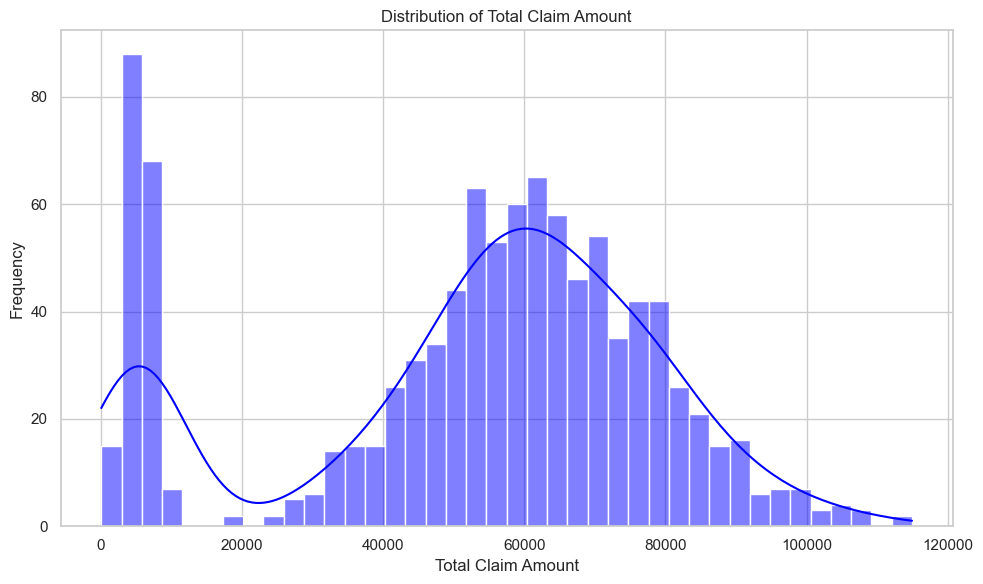

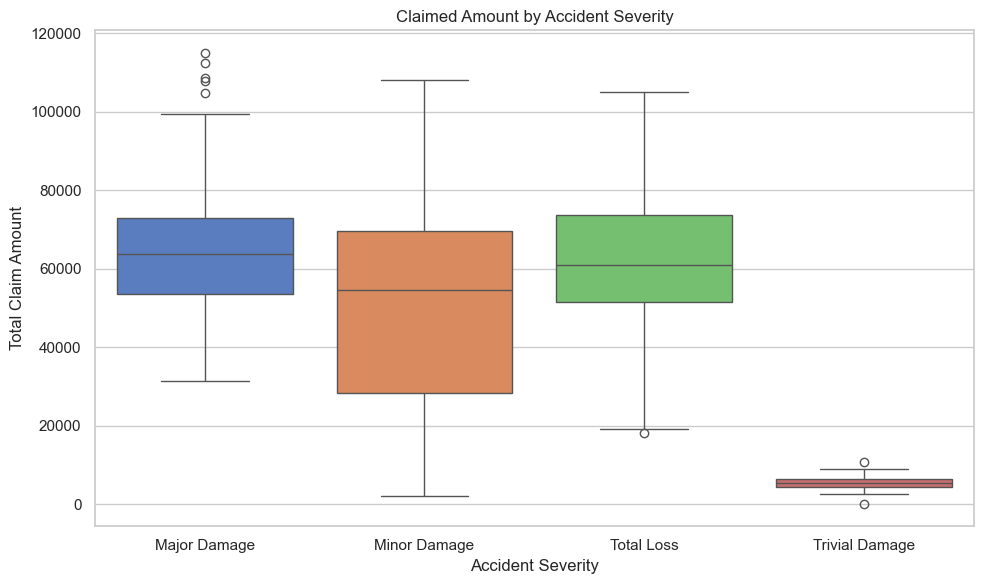

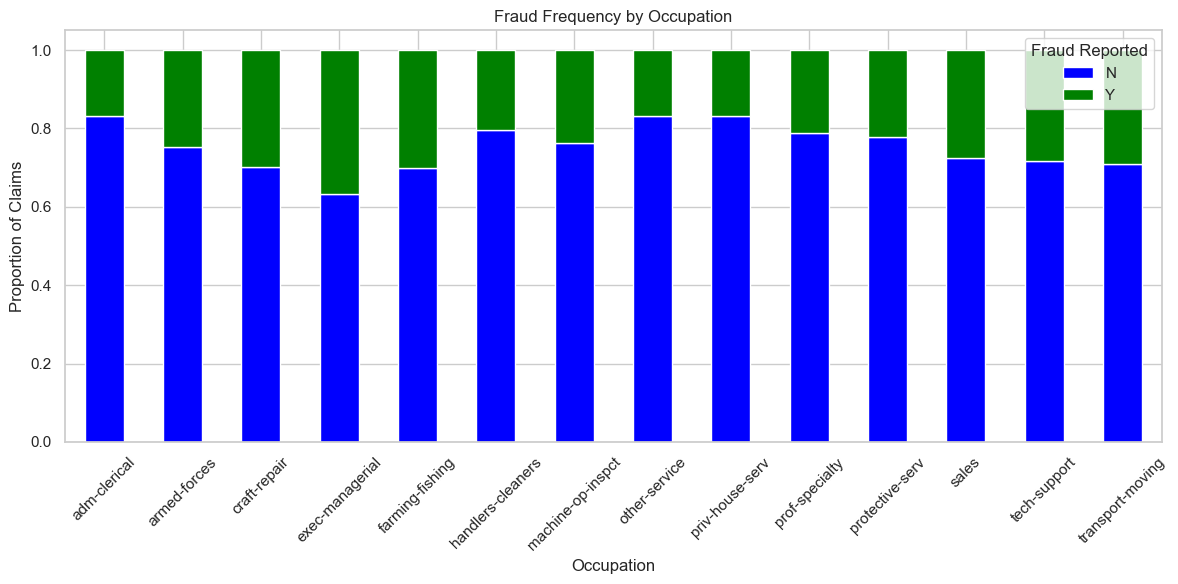

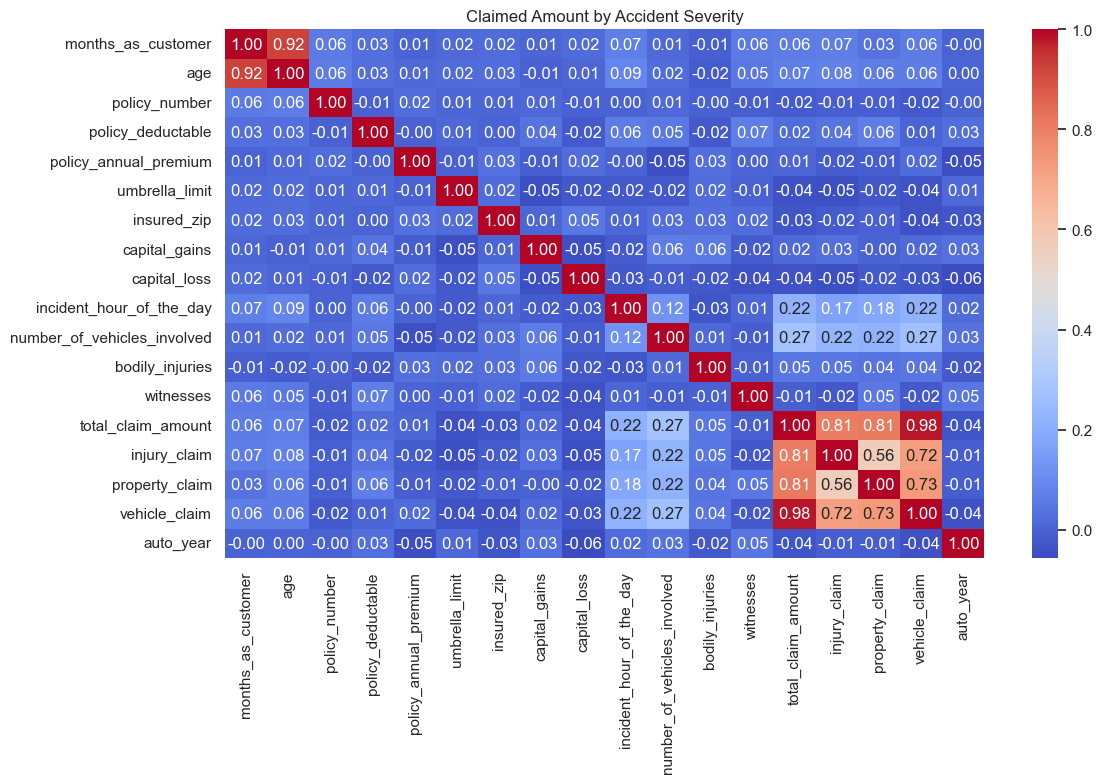

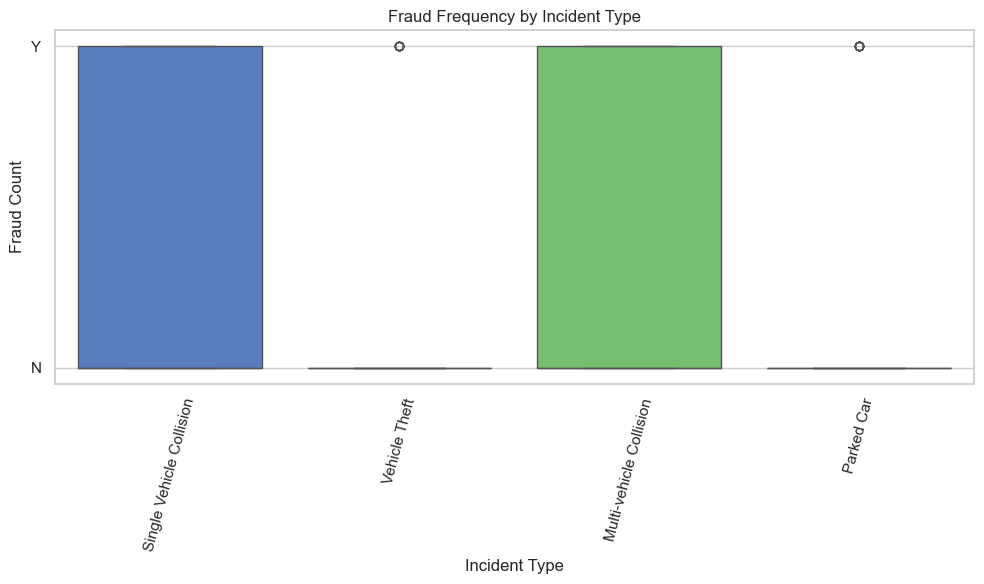

In [2]:
### Visualizations ###

import matplotlib.pyplot as plt
import seaborn as sns

# Set plot styling 
sns.set(style="whitegrid")

# Distribution of total claim amount
plt.figure(figsize=(10, 6))
sns.histplot(df['total_claim_amount'], bins=40, kde=True, color='blue')
plt.title("Distribution of Total Claim Amount")
plt.xlabel("Total Claim Amount")
plt.ylabel("Frequency")
plt. tight_layout()
plt.savefig("Distribution of Total Claim Amount.png", dpi=300, bbox_inches='tight')
plt.show()

# Boxplot of Claim Amount by Incident Severity
plt.figure(figsize=(10, 6))
sns.boxplot(x='incident_severity', y='total_claim_amount', data=df, hue='incident_severity', palette='muted', dodge=False)
plt.title("Claimed Amount by Accident Severity")
plt.xlabel("Accident Severity")
plt.ylabel("Total Claim Amount")
plt. tight_layout()
plt.savefig("Claimed Amount by Accident Severity.png", dpi=300, bbox_inches='tight')
plt.show()

# Frequency of Fraud by Occupation
# Calculate fraud rate by occupation
fraud_rate = (
    df.groupby(['insured_occupation', 'fraud_reported'])
    .size()
    .unstack(fill_value=0)
)
                
# Normalize to get proportions
fraud_rate_norm = fraud_rate.div(fraud_rate.sum(axis=1), axis=0)
                       
# Plot normalized fraud rates           
fraud_rate_norm.plot(kind='bar', stacked=True, figsize=(12, 6), color=['blue','green'])
plt.title("Fraud Frequency by Occupation")
plt.xlabel("Occupation")
plt.ylabel("Proportion of Claims")
plt.xticks(rotation=45)
plt.legend(title="Fraud Reported", loc='upper right')
plt.tight_layout()
plt.show()

# Correlation Heatmap of Numeric Features
plt.figure(figsize=(12, 8))
numeric_cols = df.select_dtypes(include='number').columns
corr_matrix = df[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Claimed Amount by Accident Severity")
plt. tight_layout()
plt.show()

# Bar plot of Fraud by Incident Type
plt.figure(figsize=(10, 6))
sns.boxplot(x='incident_type', y='fraud_reported', data=df, hue='incident_type', palette='muted', dodge=False)
plt.title("Fraud Frequency by Incident Type")
plt.xlabel("Incident Type")
plt.ylabel("Fraud Count")
plt.xticks(rotation=75)
plt. tight_layout()
plt.show()

Classification Report:
                precision    recall  f1-score   support

  Major Damage       0.40      0.33      0.36        55
  Minor Damage       0.40      0.48      0.44        71
    Total Loss       0.34      0.30      0.32        56
Trivial Damage       0.43      0.50      0.46        18

      accuracy                           0.39       200
     macro avg       0.39      0.40      0.40       200
  weighted avg       0.39      0.39      0.39       200



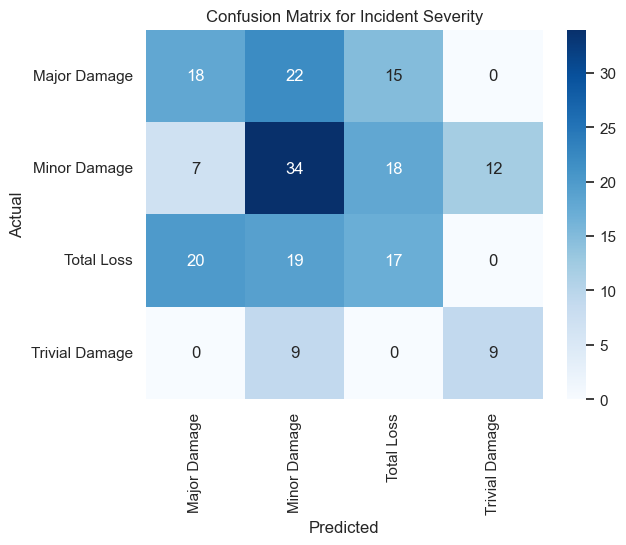

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, confusion_matrix

# Encode the target variable 'incident_severity'
df['incident_severity_encoded'] = df['incident_severity'].astype('category').cat.codes

# One-hot encode 'insured_occupation'
occupation_encoded = pd.get_dummies(df['insured_occupation'], prefix='occ')

# Combine features
X = pd.concat([df[['months_as_customer', 'total_claim_amount']], occupation_encoded], axis=1)
y = df['incident_severity_encoded']

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=69)

# Train Random Forest with class weights
clf = RandomForestClassifier(class_weight='balanced', random_state=69)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=df['incident_severity'].unique()))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=df['incident_severity'].unique(),
            yticklabels=df['incident_severity'].unique())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix for Incident Severity")
plt.show()

Classification Report:
                precision    recall  f1-score   support

  Major Damage       0.38      0.29      0.33        55
  Minor Damage       0.38      0.41      0.39        71
    Total Loss       0.37      0.39      0.38        56
Trivial Damage       0.62      0.72      0.67        18

      accuracy                           0.40       200
     macro avg       0.44      0.45      0.44       200
  weighted avg       0.40      0.40      0.40       200



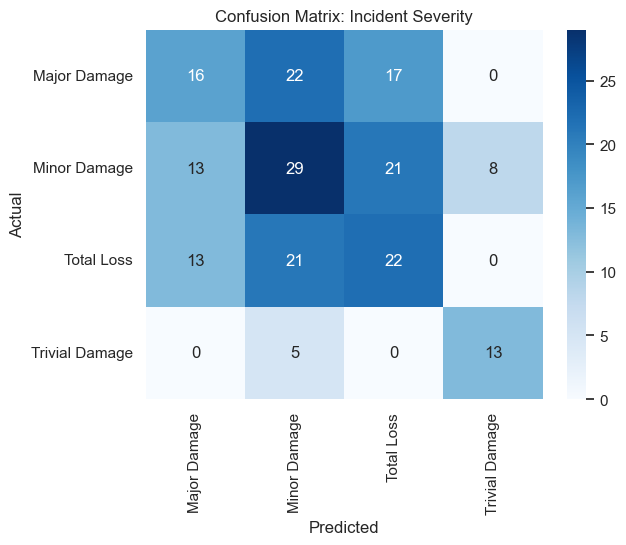

In [4]:
# Encode the target variable 'incident_severity'
df['incident_severity_encoded'] = df['incident_severity'].astype('category').cat.codes

# One-hot encode 'auto_make'
auto_make_encoded = pd.get_dummies(df['auto_make'], prefix='make')

# Combine features
X = pd.concat([df[['months_as_customer', 'total_claim_amount']], auto_make_encoded], axis=1)
y = df['incident_severity_encoded']

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=69)

# Train Random Forest with class weights
clf = RandomForestClassifier(class_weight='balanced', random_state=69)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=df['incident_severity'].unique()))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=df['incident_severity'].unique(),
            yticklabels=df['incident_severity'].unique())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Incident Severity")
plt.show()

Observation:

Accuracy increases from the previous iteration, suggesting auto_make doesn't add much predictive power when paired with total_claim_amount and months_as_customer.

Classification Report:
                precision    recall  f1-score   support

  Major Damage       0.36      0.38      0.37        55
  Minor Damage       0.35      0.31      0.33        71
    Total Loss       0.37      0.39      0.38        56
Trivial Damage       0.50      0.56      0.53        18

      accuracy                           0.38       200
     macro avg       0.40      0.41      0.40       200
  weighted avg       0.37      0.38      0.37       200



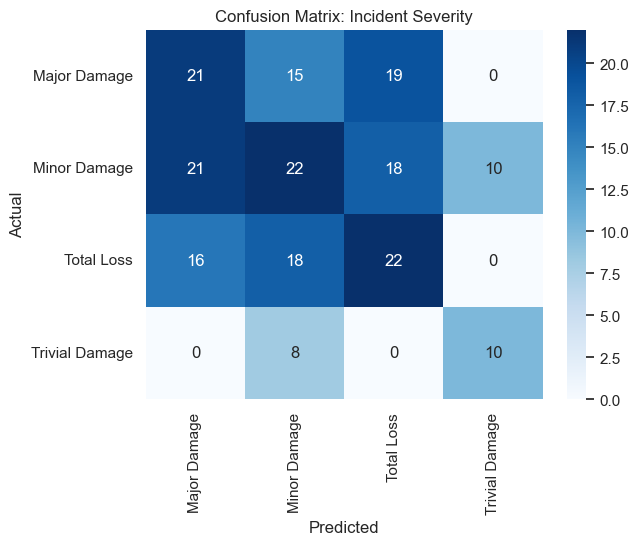

In [5]:
# Encode the target variable 'incident_severity'
df['incident_severity_encoded'] = df['incident_severity'].astype('category').cat.codes

# One-hot encode 'insured_education_level'
education_encoded = pd.get_dummies(df['insured_education_level'], prefix='edu')

# Combine features
X = pd.concat([df[['months_as_customer', 'total_claim_amount']], education_encoded], axis=1)
y = df['incident_severity_encoded']

# Train and test split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=69)

# Train Random Forest with class weights
clf = RandomForestClassifier(class_weight='balanced', random_state=69)
clf.fit(X_train, y_train)

# Predict and evaluate
y_pred = clf.predict(X_test)

# Classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=df['incident_severity'].unique()))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=df['incident_severity'].unique(),
            yticklabels=df['incident_severity'].unique())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix: Incident Severity")
plt.show()

Observation:

Accuracy decreases, suggesting insured_education_level isn't taking me in the direction needed to predict incident severity sufficiently.

Classification Report:
              precision    recall  f1-score   support

           0       0.66      0.45      0.53        89
           1       0.56      0.69      0.62        89
           2       0.56      0.61      0.58        89

    accuracy                           0.58       267
   macro avg       0.59      0.58      0.58       267
weighted avg       0.59      0.58      0.58       267



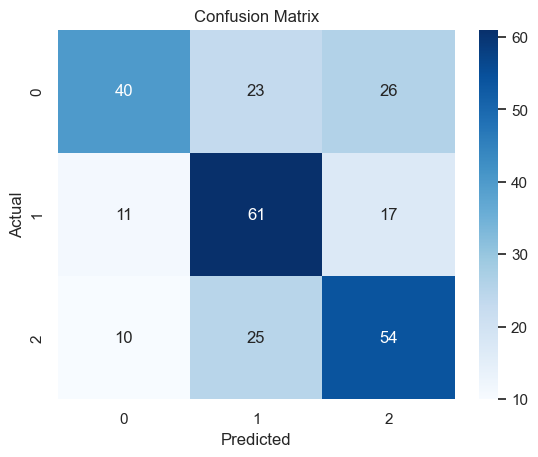


Risk Profile by insured_education_level:
predicted_severity              0         1         2
insured_education_level                              
Associate                0.427586  0.296552  0.275862
College                  0.393443  0.336066  0.270492
High School              0.475000  0.262500  0.262500
JD                       0.428571  0.217391  0.354037
MD                       0.326389  0.319444  0.354167
Masters                  0.419580  0.335664  0.244755
PhD                      0.432000  0.320000  0.248000

Risk Profile by insured_occupation:
predicted_severity         0         1         2
insured_occupation                              
adm-clerical        0.584615  0.138462  0.276923
armed-forces        0.623188  0.246377  0.130435
craft-repair        0.418919  0.324324  0.256757
exec-managerial     0.315789  0.394737  0.289474
farming-fishing     0.320755  0.396226  0.283019
handlers-cleaners   0.351852  0.370370  0.277778
machine-op-inspct   0.344086  0.311828  0.3

In [6]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.preprocessing import KBinsDiscretizer
from sklearn.feature_selection import VarianceThreshold
from imblearn.over_sampling import SMOTE

# Combine 'Minor Damage' and 'Trivial Damage' into a single class
# This simplifies the classification task from 4 to 3 classes and improves recall for low-severity claims
df['incident_severity_combined'] = df['incident_severity'].replace({
    'Minor Damage': 'Low Severity',
    'Trivial Damage': 'Low Severity'
})
df['incident_severity_encoded'] = df['incident_severity_combined'].astype('category').cat.codes

# Feature engineering and bin total claim amount into 3 quantile-based bands
# This helps normalize skewed monetary values and captures relative severity
df['claim_band'] = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='quantile')\
                    .fit_transform(df[['total_claim_amount']])

# Create interaction features to capture compound effects
# These combinations were selected based on previous EDA and revealed hidden patterns in categorical relationships
df['incident_collision'] = df['incident_type'] + "_" + df['collision_type']
df['edu_occupation'] = df['insured_education_level'] + "_" + df['insured_occupation']
df['hobby_relationship'] = df['insured_hobbies'] + "_" + df['insured_relationship']

# One-hot encode categorical features
# This converts non-numeric data into a usable format for tree-based models
encoded = pd.get_dummies(df[['insured_occupation', 'insured_hobbies',
                             'insured_relationship', 'insured_education_level',
                             'incident_type', 'collision_type',
                             'incident_collision', 'edu_occupation', 'hobby_relationship']], drop_first=True)

# Combine numeric and encoded features
# This creates a unified feature matrix for modeling
X = pd.concat([df[['months_as_customer', 'total_claim_amount', 'claim_band']], encoded], axis=1)
X.columns = X.columns.str.replace(" ", "_")  # Clean column names

# Drop low-variance features
# Remove features that don’t vary much and are unlikely to be predictive
selector = VarianceThreshold(threshold=0.01)
X_selected = selector.fit_transform(X)
selected_columns = X.columns[selector.get_support()]
X = pd.DataFrame(X_selected, columns=selected_columns)

# Apply SMOTE to balance classes
# The dataset has class imbalances, and I utilize SMOTE to generate synthetic samples to equalize class distribution
y = df['incident_severity_encoded']
X_resampled, y_resampled = SMOTE(random_state=69).fit_resample(X, y)

# Split into training and test sets
# Stratified split ensures class proportions are preserved in both sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, stratify=y_resampled, test_size=0.2, random_state=69)

# Define base models
# I selected Random Forest and XGBoost for their robustness and ability to handle mixed feature types
rf = RandomForestClassifier(n_estimators=200, random_state=69)
xgb = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=6,
                    tree_method='hist', eval_metric='mlogloss', random_state=69)

# Define stacking ensemble
# Logistic Regression as a meta-model ensures interpretability and stability
stacked = StackingClassifier(
    estimators=[('rf', rf), ('xgb', xgb)],
    final_estimator=LogisticRegression(max_iter=1000),
    cv=5
)
stacked.fit(X_train, y_train)

# Evaluate model performance
# Classification report provides precision, recall, and F1 for each class
y_pred = stacked.predict(X_test)
print("Classification Report:")
print(classification_report(y_test, y_pred))

# Visualize confusion matrix
# This helps identify which classes are being confused and where errors occur
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Generate risk profiles by categorical traits
# This helps interpret model predictions and identify behavioral patterns
df['predicted_severity'] = stacked.predict(X)
traits = ['insured_education_level', 'insured_occupation', 'insured_hobbies']
for trait in traits:
    print(f"\nRisk Profile by {trait}:")
    summary = df.groupby(trait)['predicted_severity'].value_counts(normalize=True).unstack().fillna(0)
    print(summary)